<a href="https://colab.research.google.com/github/JonatasLemos/DataAnalysisProjects/blob/main/altitudesAnalysis/MunicipalAltitudePart2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# City altitude Analysis

In [ ]:
pip install simpledbf

In [ ]:
pip install unidecode

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from simpledbf import Dbf5 as db
from unidecode import unidecode
import seaborn as sns
import numpy as np

## Reading city altitudes dbf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path_start ="/content/drive/MyDrive/Colab Data/"
dbf = db(f"{path_start}altitude_cities_mg.dbf")
df_altitudes = dbf.to_dataframe()
df_altitudes = df_altitudes.drop(columns=["LAYER","LABEL","codmun2","codmun1"])
df_altitudes = df_altitudes.rename(columns={"RASTERVALU": "ALTITUDE (m)"})
df_altitudes.head()

,NAME,ALTITUDE (m)
0,Cônego Marinho/MG,650
1,Espinosa/MG,566
2,Formoso/MG,844
3,Gameleiras/MG,519
4,Itacarambi/MG,454


## Creating intervals of altitudes

In [ ]:
df_altitudes["ALTITUDE_INTERVALS"] = pd.cut(x=df_altitudes["ALTITUDE (m)"],
  bins=[0, 300, 600, 850, 1100, 1500],labels=["0-300m","300-600m","600-850m","850-1100m","1100-1500m"])
df_altitudes["NAME"].replace("\/MG","",regex=True,inplace=True)
df_altitudes["MUNIC_UNIDECODE"] = df_altitudes["NAME"].str.lower().apply(unidecode)
df_altitudes.head()

,NAME,ALTITUDE (m),ALTITUDE_INTERVALS,MUNIC_UNIDECODE
0,Cônego Marinho,650,600-850m,conego marinho
1,Espinosa,566,300-600m,espinosa
2,Formoso,844,600-850m,formoso
3,Gameleiras,519,300-600m,gameleiras
4,Itacarambi,454,300-600m,itacarambi


## Counting number of cities per altitude category

In [ ]:
altitude_intervals = df_altitudes.groupby(["ALTITUDE_INTERVALS"])["NAME"].count()
altitude_intervals

ALTITUDE_INTERVALS
0-300m         76
300-600m      206
600-850m      327
850-1100m     214
1100-1500m     30
Name: NAME, dtype: int64

## Ploting Altitude Intervals

In [ ]:
title_font = 20
label_font = 14
plt.rcParams["figure.figsize"] = [9, 6]

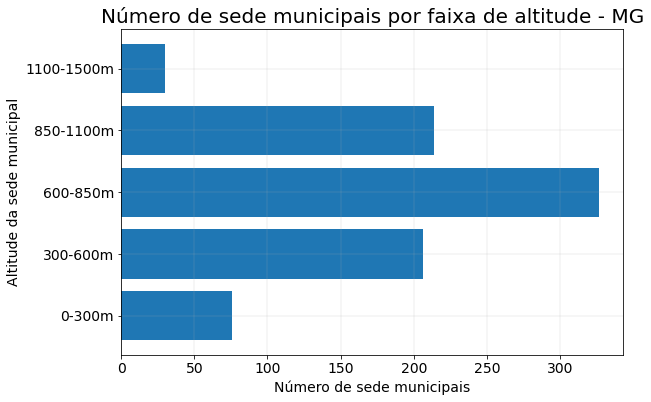

In [ ]:
plt.barh(altitude_intervals.index,altitude_intervals)
plt.title("Número de sede municipais por faixa de altitude - MG",fontsize=title_font)
plt.xlabel('Número de sede municipais',fontsize=label_font)
plt.ylabel('Altitude da sede municipal',fontsize=label_font)
plt.xticks(fontsize=label_font)
plt.yticks(fontsize=label_font)
plt.grid(lw="0.2")
plt.show()

## Reading CSV with HDI, per capta income etc.

In [ ]:
df_idh = pd.read_csv(f"{path_start}idh.csv")
df_idh.drop(["Unnamed: 0","Nome da Unidade da Federação"],inplace=True,axis=1)
df_idh["MUNIC_UNIDECODE"] = df_idh["Município"].str.lower().apply(unidecode)
df_idh[["Município","População total","População rural","IDHM","Renda per capita"]].head()

,Município,População total,População rural,IDHM,Renda per capita
0,Abadia dos Dourados,6704,2515,0.689,596.18
1,Abaeté,22690,2986,0.698,707.24
2,Abre Campo,13311,6030,0.654,444.32
3,Acaiaca,3920,1367,0.630,357.03
4,Açucena,10276,5471,0.610,325.42


In [ ]:
df_idh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 853 entries, 0 to 852
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Município                    853 non-null    object 
 1   IDHM                         853 non-null    float64
 2   Esperança de vida ao nascer  853 non-null    float64
 3   Renda per capita             853 non-null    float64
 4   Índice de Gini               853 non-null    float64
 5   População rural              853 non-null    int64  
 6   População total              853 non-null    int64  
 7   População urbana             853 non-null    int64  
 8   MUNIC_UNIDECODE              853 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 60.1+ KB


In [ ]:
wrong_names = df_altitudes[~df_altitudes['NAME'].
    isin(df_idh['Município'])]["NAME"].to_numpy()
correct_names = df_idh[~df_idh['Município'].
    isin(df_altitudes['NAME'])]["Município"].to_numpy()

In [ ]:
df_altitudes['NAME'].replace(wrong_names,correct_names,inplace=True)

In [ ]:
df_idh["Rural/Total"] = round((df_idh['População rural']/df_idh['População total'])*100,1)
df_idh[["Município","População total","População rural","Rural/Total","IDHM","Renda per capita"]].head()

,Município,População total,População rural,Rural/Total,IDHM,Renda per capita
0,Abadia dos Dourados,6704,2515,37.5,0.689,596.18
1,Abaeté,22690,2986,13.2,0.698,707.24
2,Abre Campo,13311,6030,45.3,0.654,444.32
3,Acaiaca,3920,1367,34.9,0.630,357.03
4,Açucena,10276,5471,53.2,0.610,325.42


## Merging DFS

In [ ]:
df_altitudes = df_altitudes.merge(df_idh)
df_altitudes.drop(["NAME"],axis=1,inplace=True)
df_altitudes[["Município","População total","População rural","Rural/Total","IDHM","Renda per capita","ALTITUDE (m)"]].head()

,Município,População total,População rural,Rural/Total,IDHM,Renda per capita,ALTITUDE (m)
0,Cônego Marinho,7101,5186,73.0,0.621,245.64,650
1,Espinosa,31113,13090,42.1,0.627,299.13,566
2,Formoso,8177,3004,36.7,0.640,370.41,844
3,Gameleiras,5139,3726,72.5,0.650,258.85,519
4,Itacarambi,17720,3921,22.1,0.641,321.22,454


In [ ]:
df_altitudes.to_csv(f"{path_start}idh_altitudes.csv",index=False)

## Ploting scatterplots and using polyfit to fit a line

In [ ]:
def plot_line(*args):
  m,b = np.polyfit(args[0], args[1], deg=1)
  plt.plot(args[0],args[1],"o",markersize=5)
  plt.plot(args[0], m*args[0] + b,linewidth=4,color='green')
  plt.title(args[2],fontsize=title_font)
  plt.xlabel(args[3],fontsize=label_font)
  plt.ylabel(args[4],fontsize=label_font)
  plt.xticks(fontsize=label_font)
  plt.yticks(fontsize=label_font)
  plt.grid(lw="0.2")
  plt.show()
def print_correlation(col1,col2):
  corr,pval=stats.pearsonr(col1,col2)
  print(f"Correlation:{corr: .3f}")
  print(f"P-VALUE:{pval: .5f}")

CORRELAÇÃO IDHM - POPULAÇÃO RURAL
Correlation:-0.693
P-VALUE: 0.00000


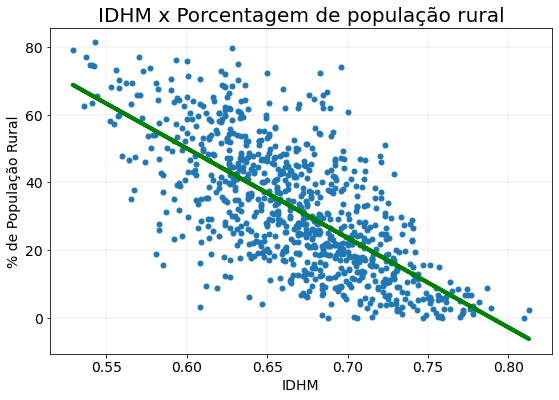

In [ ]:
print("CORRELAÇÃO IDHM - POPULAÇÃO RURAL")
print_correlation(df_altitudes['IDHM'],df_altitudes["Rural/Total"])
plot_line(df_altitudes['IDHM'],df_altitudes["Rural/Total"],"IDHM x Porcentagem de população rural",'IDHM','% de População Rural')

CORRELAÇÃO ALTITUDE RENDA PER CAPITA
Correlation: 0.229
P-VALUE: 0.00000


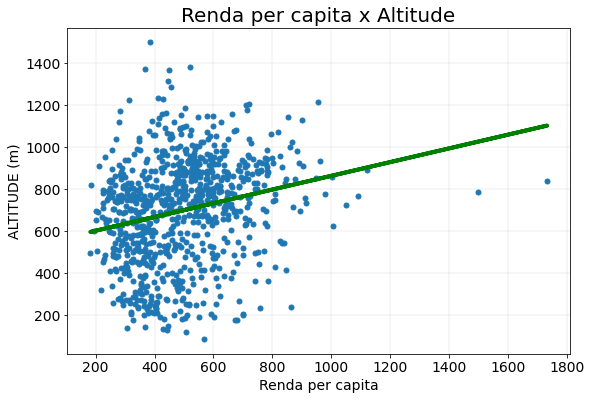

In [ ]:
print("CORRELAÇÃO ALTITUDE RENDA PER CAPITA")
print_correlation(df_altitudes['Renda per capita'],df_altitudes["ALTITUDE (m)"])
plot_line(df_altitudes['Renda per capita'],df_altitudes["ALTITUDE (m)"],"Renda per capita x Altitude",'Renda per capita','ALTITUDE (m)')

CORRELAÇÃO ALTITUDE IDHM
Correlation: 0.233
P-VALUE: 0.00000


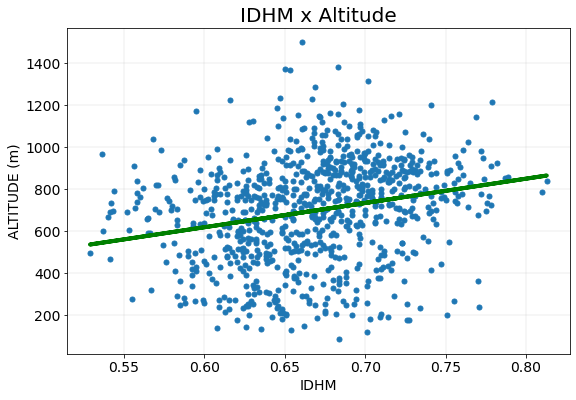

In [ ]:
print("CORRELAÇÃO ALTITUDE IDHM")
print_correlation(df_altitudes['IDHM'],df_altitudes["ALTITUDE (m)"])
plot_line(df_altitudes['IDHM'],df_altitudes["ALTITUDE (m)"],"IDHM x Altitude",'IDHM','ALTITUDE (m)')